<a href="https://colab.research.google.com/github/VVdovichev/ML_in_Business/blob/main/HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

##__1.__ Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [138]:
df = pd.read_csv('churn_data.csv')

In [139]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [140]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [141]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=42)

In [142]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [143]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [144]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [145]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

##LogisticRegression

In [146]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [147]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [148]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict(X_test)

In [149]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2003
           1       0.56      0.21      0.30       497

    accuracy                           0.81      2500
   macro avg       0.70      0.58      0.60      2500
weighted avg       0.78      0.81      0.77      2500



In [150]:
pipeline_gbc = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [151]:
pipeline_gbc.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [152]:
y_preds = pipeline_gbc.predict(X_test)

In [153]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2003
           1       0.77      0.47      0.58       497

    accuracy                           0.87      2500
   macro avg       0.82      0.72      0.75      2500
weighted avg       0.86      0.87      0.85      2500



##__2.__  Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

Лучше отработала модель бустинга. Метрику будем выбирать в зависимости от бизнес задачи, если нужно охватить больше клиентов, то будем оптимизировать recall. Если нам нужно выявить клиентов, действительно готовых к оттоку, то будем улучшать precision.

##__3.__ Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

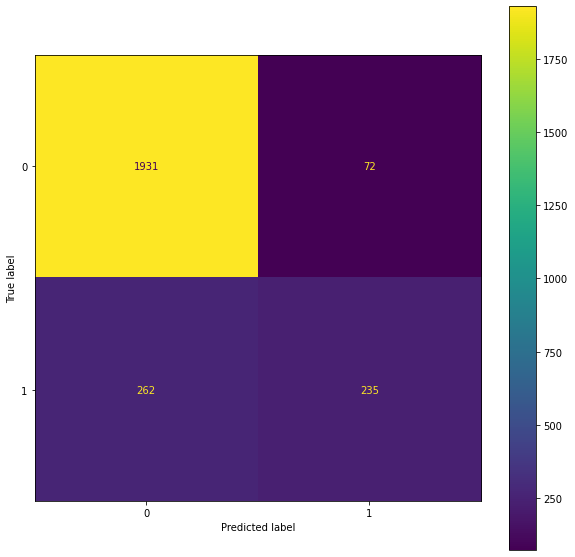

In [154]:
fig, ax = plt.subplots(figsize=(10, 10))

cm = confusion_matrix(y_test, y_preds)
cmd = ConfusionMatrixDisplay(cm)

cmd.plot(ax=ax)

Модель классифицировала 307 клиентов, готовых к оттоку. На их удержание было потраченно 307\$. В итоге только 235 клиентов удалось удержать, выручка с них составила 470\$. Чистый доход составил 163\$.





##__4.__  (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [155]:
dict_params = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__class_weight': [None, {1: 0.8, 0: 0.2}, {1: 0.7, 0: 0.3}, {1: 0.6, 0: 0.4}],
    'classifier__solver': ['lbfgs', 'saga']
}

grid_search_lr = GridSearchCV(estimator=pipeline,
                              param_grid=dict_params,
                              scoring='f1',
                              n_jobs=-1,
                              cv=3)

grid_search_lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
36 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('Geography',
                                                                        Pipeline(steps=[('selector',
                                                                                         FeatureSelector(column='Geography')),
                                                                                        ('ohe',
                                                                                         OHEEncoder(key='Geography'))])),
                                                                       ('Gender',
                                                                        Pipeline(steps=[('selector',
                                                                                         FeatureSelector(column='Gender')),
                                                                                        ('o

In [156]:
grid_search_lr.best_params_, grid_search_lr.best_score_

({'classifier__class_weight': {0: 0.2, 1: 0.8},
  'classifier__penalty': 'l1',
  'classifier__solver': 'saga'},
 0.4932898358356665)

In [157]:
dict_params = grid_search_lr.best_params_
dict_params = dict(zip([x.split('__')[1] for x in list(dict_params.keys())], dict_params.values()))

dict_params

{'class_weight': {0: 0.2, 1: 0.8}, 'penalty': 'l1', 'solver': 'saga'}

In [158]:
pipeline_lr = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42, **dict_params)),
])

In [159]:
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [160]:
y_pred_lr = pipeline_lr.predict(X_test)

In [161]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      2003
           1       0.37      0.71      0.49       497

    accuracy                           0.70      2500
   macro avg       0.64      0.70      0.64      2500
weighted avg       0.80      0.70      0.73      2500



In [162]:
dict_params = {
    'classifier__min_samples_split': [100],
    'classifier__min_samples_leaf': [5, 10, 15],
    'classifier__max_depth': [5, 10, 15]
}

grid_search_gbc = GridSearchCV(estimator=pipeline_gbc,
                               param_grid=dict_params,
                               scoring='f1',
                               n_jobs=-1,
                               cv=3)

grid_search_gbc.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('Geography',
                                                                        Pipeline(steps=[('selector',
                                                                                         FeatureSelector(column='Geography')),
                                                                                        ('ohe',
                                                                                         OHEEncoder(key='Geography'))])),
                                                                       ('Gender',
                                                                        Pipeline(steps=[('selector',
                                                                                         FeatureSelector(column='Gender')),
                                                                                        ('o

In [163]:
grid_search_gbc.best_params_, grid_search_gbc.best_score_

({'classifier__max_depth': 5,
  'classifier__min_samples_leaf': 5,
  'classifier__min_samples_split': 100},
 0.5916234935450091)

In [164]:
dict_params = grid_search_gbc.best_params_
dict_params = dict(zip([x.split('__')[1] for x in list(dict_params.keys())], dict_params.values()))

dict_params

{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 100}

In [165]:
pipeline_new_gbc = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42, **dict_params)),
])

In [166]:
pipeline_new_gbc.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [167]:
y_pred_gbc = pipeline_new_gbc.predict(X_test)

In [168]:
print(classification_report(y_test, y_pred_gbc))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2003
           1       0.76      0.49      0.59       497

    accuracy                           0.87      2500
   macro avg       0.82      0.72      0.76      2500
weighted avg       0.86      0.87      0.86      2500



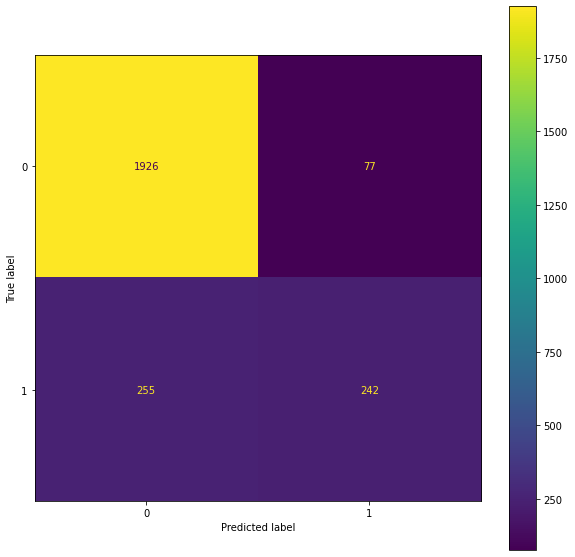

In [169]:
fig, ax = plt.subplots(figsize=(10, 10))

cm = confusion_matrix(y_test, y_pred_gbc)
cmd = ConfusionMatrixDisplay(cm)

cmd.plot(ax=ax)

##__5.__ (опционально) Еще раз провести оценку экономической эффективности

Модель классифицировала 319 клиентов, готовых к оттоку. На их удержание было потраченно 319\$. В итоге только 242 клиентов удалось удержать, выручка с них составила 484\$. Чистый доход составил 165\$.